# Modelling Lap Times at the United States Grand Prix using GPs

*Unit 7 Project*

In this project, I'm going to use data from each lap of the 2023 United States Grand Prix at the Circuit of the Americas to model how lap times progress throughout the race.

In [1]:
!pip install bambi
!pip install preliz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.2/109.2 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 763.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.1/517.1 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 8.4 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1


In [2]:
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import xarray as xr
import bambi as bmb
import pymc as pm
import preliz as pz

In [3]:
url = "https://raw.githubusercontent.com/blortle-dev/data-science-lasa/refs/heads/main/resources/lap_times.csv"
data = pd.read_csv(url)

## Data Prep

I'll start to prepare my data by filtering to only incluide the 2023 US Grand Prix.

In [4]:
data = data[data["raceId"] == 1116]
data

,raceId,driverId,lap,position,time,milliseconds
557007,1116,846,1,1,1:41.712,101712
557008,1116,846,2,1,1:41.982,101982
557009,1116,846,3,1,1:42.280,102280
557010,1116,846,4,1,1:42.331,102331
557011,1116,846,5,1,1:42.244,102244
...,...,...,...,...,...,...
558016,1116,844,52,5,1:42.190,102190
558017,1116,844,53,6,1:42.656,102656
558018,1116,844,54,6,1:41.882,101882
558019,1116,844,55,6,1:42.519,102519


Now, let's take a look at our data:

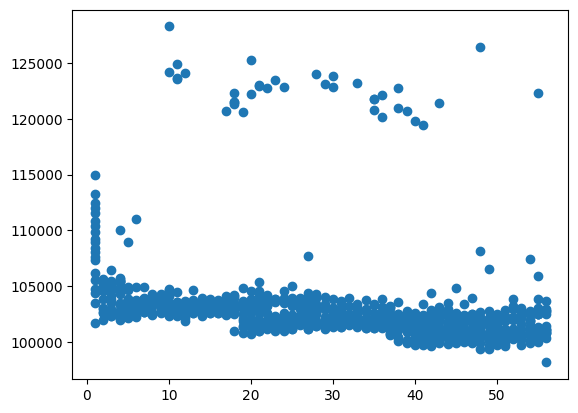

In [5]:
plt.scatter(x=data["lap"], y=data["milliseconds"])

This scatter plot shows us some pretty interesting data. For example, we can roughly estimate where in the race the most pitstops occured (~lap 19 and 37) due to the drop in lap times. We can also see the laps that were pitted on around the top of the graph, which might end up harming our model in the future. (foreshadowing?)

Anyways, let's make our first model. I stole this code from the Unit 7 Answer Key, by the way.

In [6]:
def get_ig_params(x_vals, l_b=None, u_b=None, mass=0.96, plot=False):
    """
    Returns a weakly informative prior for the length-scale parameter of the GP kernel.
    """

    differences = np.abs(np.subtract.outer(x_vals, x_vals))
    if l_b is None:
        l_b = np.min(differences[differences != 0]) * 2
    if u_b is None:
        u_b = np.max(differences) / 1.5

    dist = pz.InverseGamma()
    pz.maxent(dist, l_b, u_b, mass, plot=plot)

    return dict(zip(dist.param_names, dist.params))

In [7]:
ms = data["milliseconds"].values
lap = data["lap"].values[:,None]

In [8]:
with pm.Model() as model_hsgp:
    #prior for our smoothness parameter
    ℓ = pm.InverseGamma('ℓ', **get_ig_params(lap))

    #this is our kernal, which decides how our points relate to one another
    cov = pm.gp.cov.ExpQuad(1, ls=ℓ)
    #this specfices that we're using an HSGP
    gp = pm.gp.HSGP(m=[10], c=1.5, cov_func=cov)

    #f is for function, as in the function we use to transform our data
    f = gp.prior('f', X=lap)
    #prior for the neg binomial
    α = pm.HalfNormal('α', 1)
    #likelihood
    y = pm.NegativeBinomial("y", np.exp(f), α, observed=ms)

    idata_hsgp = pm.sample()

Output()

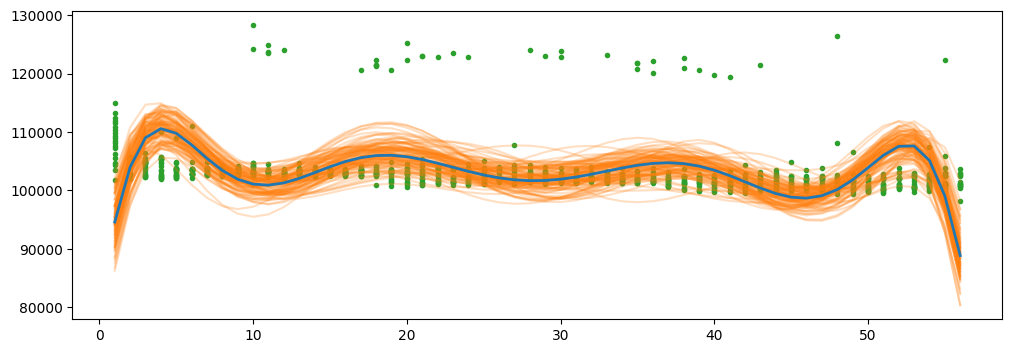

In [9]:
flat_lap = data["lap"].values.flatten()

#set up plot
_, ax = plt.subplots(1, 1, figsize=(12, 4))
#plot raw data
ax.plot(flat_lap, ms, "C2.")

#grab posterior
f = az.extract(idata_hsgp, group="posterior", var_names="f")

idx = np.argsort(flat_lap)
#plot samples of the posterior
ax.plot(flat_lap[idx], np.exp(f.values[idx,:100]), alpha=0.25, color="C1")

#plot posterior mean
ax.plot(flat_lap[idx], np.exp(f.values[idx].mean(1)), color="C0", lw=2)


That seems to overfit a bit. Let's tweak some of the values:

In [10]:
with pm.Model() as model_hsgp_v2:
    #prior for our smoothness parameter
    ℓ = pm.Gamma('ℓ', alpha=2, beta=1) # switched from InverseGamma to Gamma

    #this is our kernal, which decides how our points relate to one another
    cov = pm.gp.cov.ExpQuad(1, ls=ℓ)
    #this specfices that we're using an HSGP
    gp = pm.gp.HSGP(m=[5], c=1.5, cov_func=cov) # lowered this to (maybe?) fix it

    #f is for function, as in the function we use to transform our data
    f = gp.prior('f', X=lap)
    #prior for the neg binomial
    α = pm.HalfNormal('α', 1)
    #likelihood
    y = pm.NegativeBinomial("y", np.exp(f), α, observed=ms)

    idata_hsgp_v2 = pm.sample()

Output()

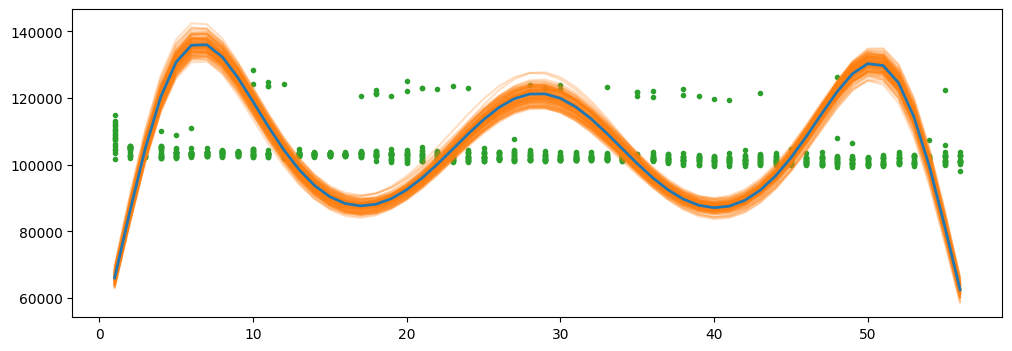

In [11]:
flat_lap = data["lap"].values.flatten()

#set up plot
_, ax = plt.subplots(1, 1, figsize=(12, 4))
#plot raw data
ax.plot(flat_lap, ms, "C2.")

#grab posterior
f = az.extract(idata_hsgp_v2, group="posterior", var_names="f")

idx = np.argsort(flat_lap)
#plot samples of the posterior
ax.plot(flat_lap[idx], np.exp(f.values[idx,:100]), alpha=0.25, color="C1")

#plot posterior mean
ax.plot(flat_lap[idx], np.exp(f.values[idx].mean(1)), color="C0", lw=2)

That is.. much worse. Let's try one more time.

In [12]:
with pm.Model() as model_hsgp_v3:
    #prior for our smoothness parameter
    ℓ = pm.InverseGamma('ℓ', **get_ig_params(lap)) # went back to the original one lol

    #this is our kernal, which decides how our points relate to one another
    cov = pm.gp.cov.ExpQuad(1, ls=ℓ)
    #this specfices that we're using an HSGP
    gp = pm.gp.HSGP(m=[15], c=1.5, cov_func=cov) # maybe i changed that the wrong direction

    #f is for function, as in the function we use to transform our data
    f = gp.prior('f', X=lap)
    #prior for the neg binomial
    α = pm.HalfNormal('α', 1)
    #likelihood
    y = pm.NegativeBinomial("y", np.exp(f), α, observed=ms)

    idata_hsgp_v3 = pm.sample()

Output()

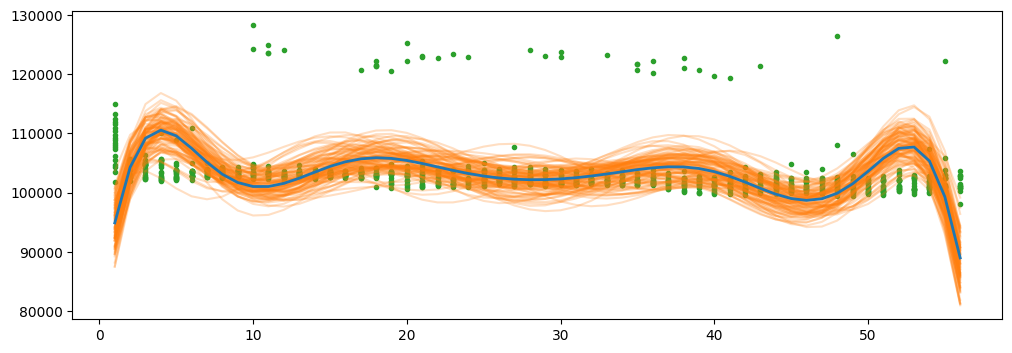

In [13]:
flat_lap = data["lap"].values.flatten()

#set up plot
_, ax = plt.subplots(1, 1, figsize=(12, 4))
#plot raw data
ax.plot(flat_lap, ms, "C2.")

#grab posterior
f = az.extract(idata_hsgp_v3, group="posterior", var_names="f")

idx = np.argsort(flat_lap)
#plot samples of the posterior
ax.plot(flat_lap[idx], np.exp(f.values[idx,:100]), alpha=0.25, color="C1")

#plot posterior mean
ax.plot(flat_lap[idx], np.exp(f.values[idx].mean(1)), color="C0", lw=2)

What if I tried with a different distribution for the likelihood?

In [14]:
with pm.Model() as model_hsgp_v4:
    #prior for our smoothness parameter
    ℓ = pm.InverseGamma('ℓ', **get_ig_params(lap)) # went back to the original one lol

    #this is our kernal, which decides how our points relate to one another
    cov = pm.gp.cov.ExpQuad(1, ls=ℓ)
    #this specfices that we're using an HSGP
    gp = pm.gp.HSGP(m=[15], c=1.5, cov_func=cov) # maybe i changed that the wrong direction

    #f is for function, as in the function we use to transform our data
    f = gp.prior('f', X=lap)
    #prior for the neg binomial
    # α = pm.HalfNormal('α', 1)
    #likelihood
    y = pm.HalfNormal("y", np.exp(f), observed=ms) # made this a halfnormal

    idata_hsgp_v4 = pm.sample()

Output()

This model ran a lot faster. Let's see the results:

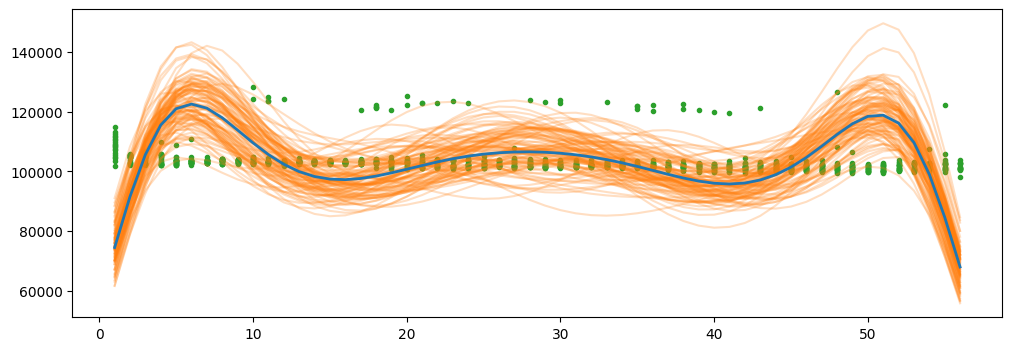

In [15]:
flat_lap = data["lap"].values.flatten()

#set up plot
_, ax = plt.subplots(1, 1, figsize=(12, 4))
#plot raw data
ax.plot(flat_lap, ms, "C2.")

#grab posterior
f = az.extract(idata_hsgp_v4, group="posterior", var_names="f")

idx = np.argsort(flat_lap)
#plot samples of the posterior
ax.plot(flat_lap[idx], np.exp(f.values[idx,:100]), alpha=0.25, color="C1")

#plot posterior mean
ax.plot(flat_lap[idx], np.exp(f.values[idx].mean(1)), color="C0", lw=2)

While the model did run faster, it ended up being a worse fit, in my opinion. What if we removed the outlier data (values above 115000)?

In [29]:
filtered_data = data[data['milliseconds'] < 150000]

In [17]:
filtered_ms = filtered_data["milliseconds"].values
filtered_lap = filtered_data["lap"].values[:,None]

In [18]:
# "shell" of model v1, as it had a similar fit to v3 but ran faster

with pm.Model() as model_hsgp_v5:
    #prior for our smoothness parameter
    ℓ = pm.InverseGamma('ℓ', **get_ig_params(filtered_lap))

    #this is our kernal, which decides how our points relate to one another
    cov = pm.gp.cov.ExpQuad(1, ls=ℓ)
    #this specfices that we're using an HSGP
    gp = pm.gp.HSGP(m=[10], c=1.5, cov_func=cov)

    #f is for function, as in the function we use to transform our data
    f = gp.prior('f', X=filtered_lap)
    #prior for the neg binomial
    α = pm.HalfNormal('α', 1)
    #likelihood
    y = pm.NegativeBinomial("y", np.exp(f), α, observed=filtered_ms)

    idata_hsgp_v5 = pm.sample()

Output()

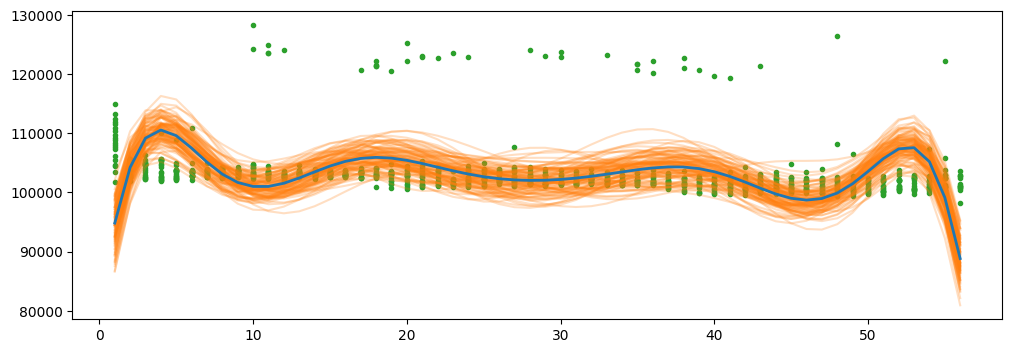

In [19]:
filtered_flat_lap = filtered_data["lap"].values.flatten()

#set up plot
_, ax = plt.subplots(1, 1, figsize=(12, 4))
#plot raw data
ax.plot(filtered_flat_lap, filtered_ms, "C2.")

#grab posterior
f = az.extract(idata_hsgp_v5, group="posterior", var_names="f")

idx = np.argsort(filtered_flat_lap)
#plot samples of the posterior
ax.plot(filtered_flat_lap[idx], np.exp(f.values[idx,:100]), alpha=0.25, color="C1")

#plot posterior mean
ax.plot(filtered_flat_lap[idx], np.exp(f.values[idx].mean(1)), color="C0", lw=2)

Not sure why it's still showing data that we excluded. I'll check the scatter plot of filtered_data:

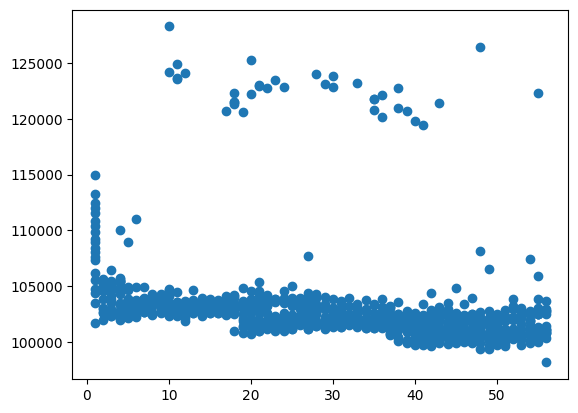

In [30]:
plt.scatter(x=filtered_data["lap"], y=filtered_data["milliseconds"])

Well, that didn't work. I'll share my final thoughts in the conclusion.

## Conclusion

So, which model was the best? For me, it's between these two:

**Version 1**
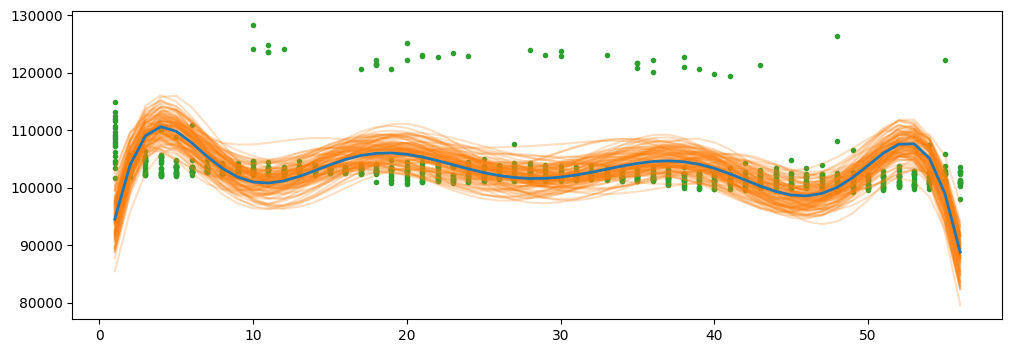

and **Version 3**:
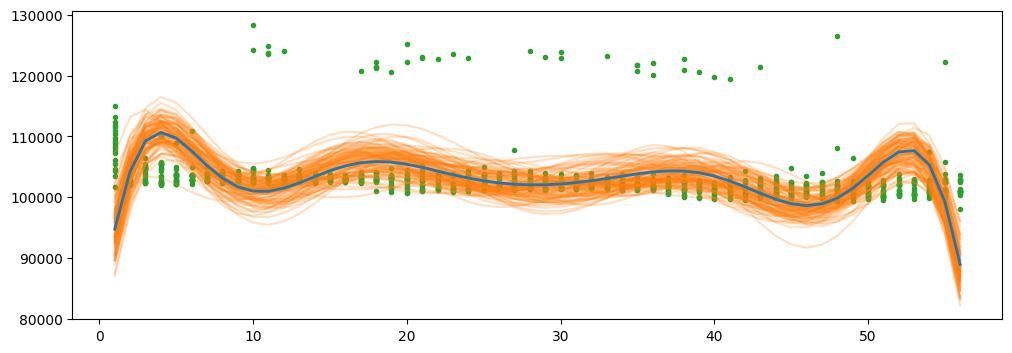

But after taking into account model speed, I think that Version 1 is the **best fit model for my data**. Not only was it the second fastest model to run, it also proved to be relatively accurate to my dataset. I wasn't able to remove the outlier laps and remake a model without them (pandas decided I couldn't lol), which is a bit of a disappointing result. However, I think the model I created is a good start to build off of and maybe make more accurate in the future.